## Analyze Compressed Algorithm Trading Histories Stored in S3

This notebook is a guide on how to analyze minute-by-minute, intraday algorithm backtest trading histories stored in S3 from the repository: https://github.com/AlgoTraders/stock-analysis-engine with additional documentation: https://stock-analysis-engine.readthedocs.io/en/latest/

In [1]:
import datetime
import boto3
import pandas as pd
import analysis_engine.consts as consts
import analysis_engine.plot_trading_history as plot_trading_history
import analysis_engine.load_history_dataset as load_history_utils

### Set Bucket and Key

You can browse for keys in Minio or find a bucket + key from the log to use this notebook for analyzing an algorithm's trading history stored in Minio (my container is hosting it at http://minio-jay:9000) in the autogenerated bucket named: **bt-spy-williamsr-2018-12-05-22-44-50-714400** with an s3 file key named:  **-181.55_netgain_9818.45_netvalue_NEGATIVE_10000.0_startbalance_1710.95_endbalance_30_shares_270.25_close_3_buys_0_sells_1_minbuyinds_1_minsellinds_43.52_seconds_trade_history-SPY_williamsr_test_0.73_for_176_of_24000.json** 

```
2018-12-05 22:54:15,696 - ae.algo - INFO - history publish - START - williamsr_test_0.73_for_176_of_24000 - ticker=SPY file=None size=12.0MB s3=minio-jay:9000/bt-spy-williamsr-2018-12-05-22-44-50-714400 s3_key=-181.55_netgain_9818.45_netvalue_NEGATIVE_10000.0_startbalance_1710.95_endbalance_30_shares_270.25_close_3_buys_0_sells_1_minbuyinds_1_minsellinds_43.52_seconds_trade_history-SPY_williamsr_test_0.73_for_176_of_24000.json redis=False redis_key=None slack=False
```

In [2]:
s3_bucket = "bt-spy-williamsr-2018-12-07-00-23-06-296627" 
s3_key = "-999.1_netgain_9000.9_netvalue_NEGATIVE_10000.0_startbalance_9000.9_endbalance_0_shares_269.94_close_151_buys_53_sells_1_minbuyinds_1_minsellinds_49.74_seconds_trade_history-SPY_williamsr_test_22.86_for_2560_of_11200.json"

## View Algorithm Backtest Performance

In [3]:
load_res = load_history_utils.load_history_dataset(s3_bucket=s3_bucket, s3_key=s3_key, compress=True)
algo_name = load_res.get('algo_name', None)
algo_config = load_res.get('algo_config_dict', None)
tickers = load_res.get('tickers', ['SPY'])
ticker = tickers[0]
history_df = load_res[ticker]

print('algo: {}\nlast trading date: {}\n\nstarting balance: {}\nend balance: {}\nnet gain: {}\nnumber of shares: {}'.format(
    algo_name,
    history_df['date'].iloc[-1],
    history_df['balance'].iloc[0],
    history_df['balance'].iloc[-1],
    history_df['net_gain'].iloc[-1],
    history_df['num_owned'].iloc[-1]))

algo: williamsr_test_22.86_for_2560_of_11200
last trading date: 2018-12-06 00:00:00

starting balance: 10000.0
end balance: 9000.9
net gain: -999.1
number of shares: 0.0


### Prepare Trading History Dataset

In [4]:
history_df['date'] = pd.to_datetime(history_df['date'])
history_df['minute'] = pd.to_datetime(history_df['minute'])
ticker = history_df['ticker'].iloc[0]
first_date = history_df['date'].iloc[0]
end_date = history_df['date'].iloc[-1]
title = 'Trading History {}\nBacktest dates from {} to {}'.format(
        ticker,
        first_date,
        end_date)
use_xcol = 'date'
use_as_date_format = '%d\n%b'
use_minute = False
if 'minute' in history_df:
    found_valid_minute = history_df['minute'].iloc[0]
    if found_valid_minute:
        use_minute = True

if use_minute:
    use_xcol = 'minute'
    use_as_date_format = '%d %H:%M:%S\n%b'
xlabel = 'Dates vs Algo values'
ylabel = 'Algo values'
df_filter = (history_df['close'] > 1.00)

# set default plots, colors and labels:
red = None
red_color = consts.PLOT_COLORS['red']
red_label = None
blue = None
blue_color = consts.PLOT_COLORS['blue']
blue_label = None
green = None
green_color = consts.PLOT_COLORS['green']
green_label = None
orange = None
orange_color = consts.PLOT_COLORS['orange']
orange_label = None

print('plotting history df with columns: {}'.format(history_df.columns.values))

plotting history df with columns: ['algo_price_change' 'algo_start_price' 'algo_status' 'ask' 'balance'
 'balance_net_gain' 'bid' 'breakeven_price' 'buy_hold_units' 'close'
 'commission' 'date' 'ds_id' 'err' 'exp_date' 'high' 'high_ask' 'high_bid'
 'high_delta' 'high_exp_date' 'high_extrinsic' 'high_gamma'
 'high_impl_vol' 'high_intrinsic' 'high_max_covered' 'high_open_int'
 'high_rho' 'high_strike' 'high_theo_price' 'high_theo_volatility'
 'high_theta' 'high_vega' 'high_volume' 'low' 'low_ask' 'low_bid'
 'low_delta' 'low_exp_date' 'low_extrinsic' 'low_gamma' 'low_impl_vol'
 'low_intrinsic' 'low_max_covered' 'low_open_int' 'low_rho' 'low_strike'
 'low_theo_price' 'low_theo_volatility' 'low_theta' 'low_vega'
 'low_volume' 'max_loss' 'max_profit' 'min_buy_indicators'
 'min_sell_indicators' 'minute' 'net_gain' 'net_value' 'note'
 'num_indicators' 'num_indicators_buy' 'num_indicators_sell' 'num_owned'
 'open' 'original_balance' 'prev_balance' 'prev_num_owned'
 'sell_hold_units' 'spread_id'

## Plot Close vs Indicator-Specific Values

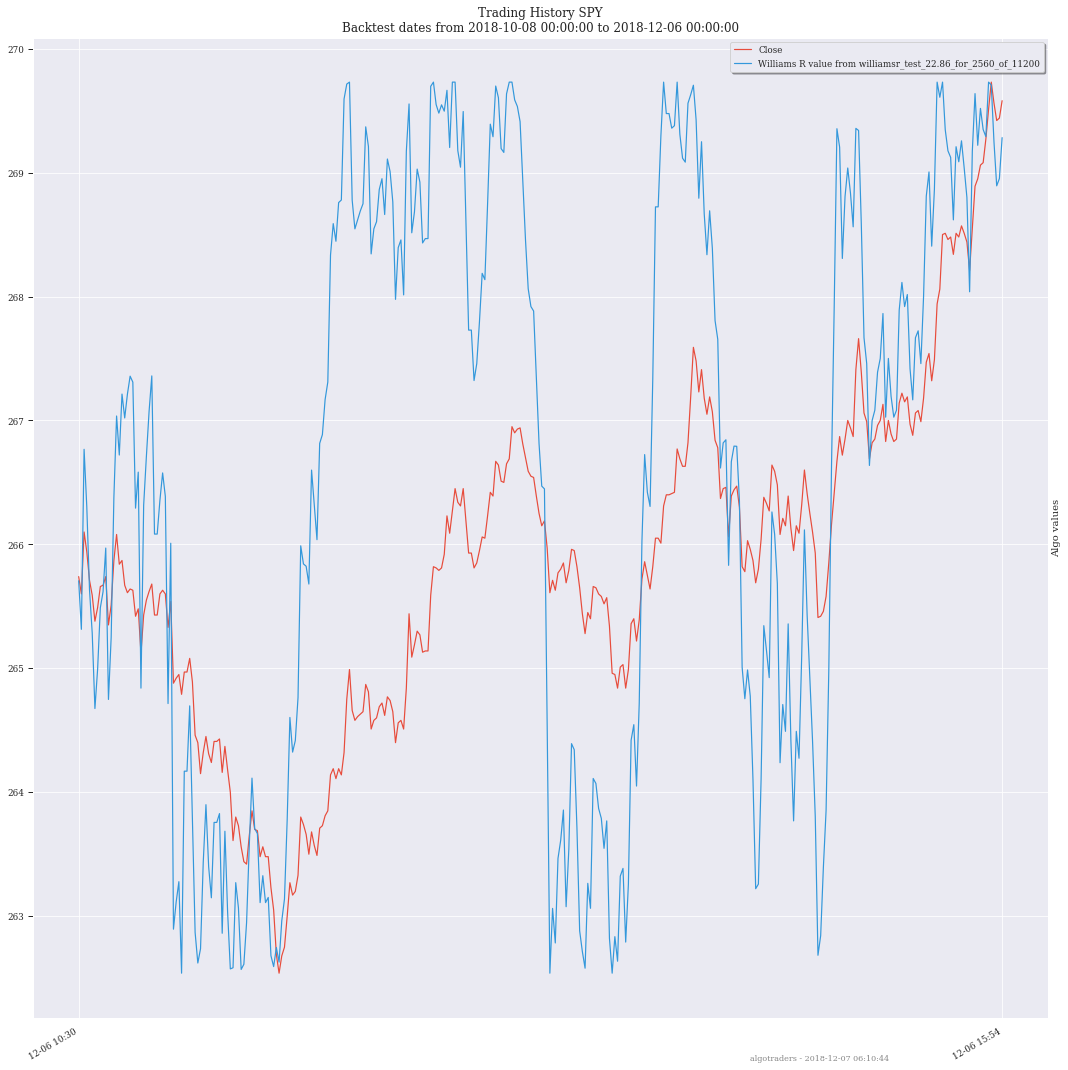

In [5]:
red = 'close'
red_label = 'Close'
blue = 'williamsr_60_200_501_conf_willr_value'
blue_label = 'Williams R value from {}'.format(algo_name)

start_index = -390  # trading day has 390 minutes

plot_res = plot_trading_history.plot_trading_history(
    title=title,
    df=history_df[start_index:],
    red=red,
    red_color=red_color,
    red_label=red_label,
    blue=blue,
    blue_color=blue_color,
    blue_label=blue_label,
    green=green,
    green_label=green_label,
    green_color=green_color,
    orange=orange,
    orange_label=orange_label,
    orange_color=orange_color,
    date_col=use_xcol,
    date_format=use_as_date_format,
    xlabel=xlabel,
    ylabel=ylabel,
    df_filter=df_filter,
    show_plot=True,
    dropna_for_all=True)

## Plot Close vs Algorithm Balance

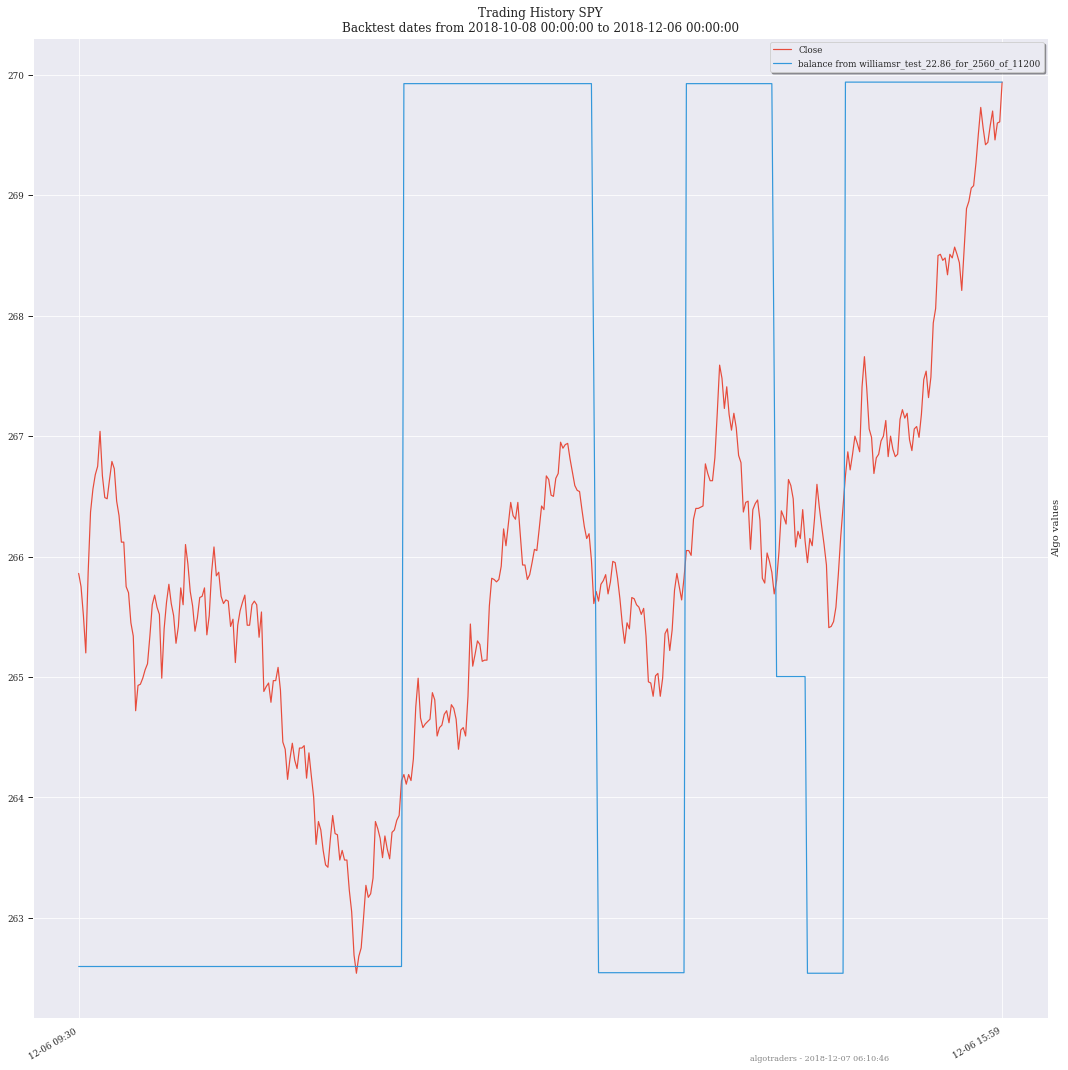

In [6]:
red = 'close'
red_label = 'Close'
blue = 'balance'
blue_label = 'balance from {}'.format(algo_name)

start_index = -390  # trading day has 390 minutes

plot_res = plot_trading_history.plot_trading_history(
    title=title,
    df=history_df[start_index:],
    red=red,
    red_color=red_color,
    red_label=red_label,
    blue=blue,
    blue_color=blue_color,
    blue_label=blue_label,
    green=green,
    green_label=green_label,
    green_color=green_color,
    orange=orange,
    orange_label=orange_label,
    orange_color=orange_color,
    date_col=use_xcol,
    date_format=use_as_date_format,
    xlabel=xlabel,
    ylabel=ylabel,
    df_filter=df_filter,
    show_plot=True,
    dropna_for_all=True)

## Replay this Backtest from the Trading History

Assuming the algorithm and indicator modules are available inside the Jupyter container you can replay this algorithm with:

In [7]:
import analysis_engine.algo as base_algo
import analysis_engine.run_algo as run_algo

ticker = algo_config['ticker']
algo_obj = base_algo.BaseAlgo(ticker=ticker, config_dict=algo_config)

print('algo started at: {}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
algo_res = run_algo.run_algo(ticker=ticker, algo=algo_obj, raise_on_err=True)
print('algo ended at: {}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

if algo_res['status'] != consts.SUCCESS:
    print(
        'failed running algo backtest '
        '{} hit status: {} error: {}'.format(
            algo_obj.get_name(),
            consts.get_status(status=algo_res['status']),
            algo_res['err']))

algo started at: 2018-12-07 06:10:47
algo ended at: 2018-12-07 06:11:29


## Plot the Backtest Replay Trading History

backtest: williamsr_test_22.86_for_2560_of_11200 SUCCESS
plotting history


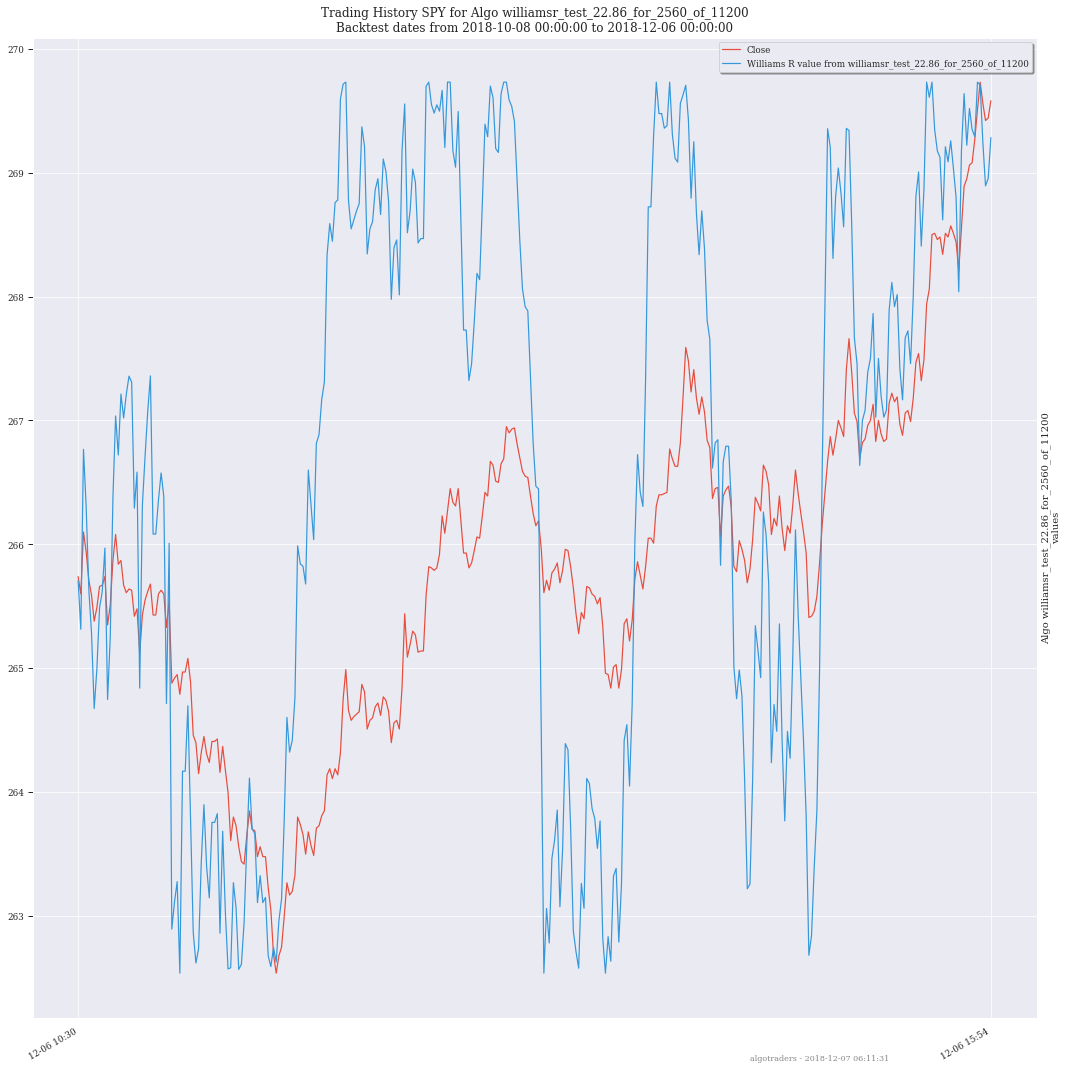

In [8]:
print(
    'backtest: {} {}'.format(
        algo_obj.get_name(),
        consts.get_status(status=algo_res['status'])))

trading_history_dict = algo_obj.get_history_dataset()
replay_df = trading_history_dict[ticker]

if not hasattr(history_df, 'to_json'):
    print('no history to plot')
else:
    print('plotting history')

    first_date = replay_df['date'].iloc[0]
    end_date = replay_df['date'].iloc[-1]
    title = (
        'Trading History {} for Algo {}\n'
        'Backtest dates from {} to {}'.format(
            ticker,
            trading_history_dict['algo_name'],
            first_date,
            end_date))
    use_xcol = 'date'
    use_as_date_format = '%d\n%b'
    if algo_config['timeseries'] == 'minute':
        use_xcol = 'minute'
        use_as_date_format = '%d %H:%M:%S\n%b'
    xlabel = 'Dates vs {} values'.format(
        trading_history_dict['algo_name'])
    ylabel = 'Algo {}\nvalues'.format(
        trading_history_dict['algo_name'])
    df_filter = (replay_df['close'] > 0.01)
    
    red = 'close'
    red_label = 'Close'
    blue = 'williamsr_60_200_501_conf_willr_value'
    blue_label = 'Williams R value from {}'.format(algo_name)

    start_index = -390  # trading day has 390 minutes

    plot_res = plot_trading_history.plot_trading_history(
        title=title,
        df=replay_df[start_index:],
        red=red,
        red_color=red_color,
        red_label=red_label,
        blue=blue,
        blue_color=blue_color,
        blue_label=blue_label,
        green=green,
        green_label=green_label,
        green_color=green_color,
        orange=orange,
        orange_label=orange_label,
        orange_color=orange_color,
        date_col=use_xcol,
        date_format=use_as_date_format,
        xlabel=xlabel,
        ylabel=ylabel,
        df_filter=df_filter,
        show_plot=True,
        dropna_for_all=True)

## Additional Details stored in the Trading History

The lastest trading history stores all of the configuration data to quickly replay and extract the best-of algorithm's based off of trading performance.

### Indicator Configuration

In [9]:
print('{} indicator config: {}'.format(algo_name, consts.ppj(algo_config.get('indicators', []))))

williamsr_test_22.86_for_2560_of_11200 indicator config: [
    {
        "buy_below": -79,
        "category": "technical",
        "is_buy": null,
        "is_sell": null,
        "module_path": "/opt/ae/ae/indicators/williamsr.py",
        "name": "williamsr",
        "num_points": 43,
        "sell_above": -18,
        "type": "momentum",
        "uses_data": "minute",
        "verbose": false,
        "willr_value": null
    }
]


## View the Algorithm's Configuration

In [10]:
print('algo {} version {} has config: {}'.format(algo_name, algo_config.get('version', '1'), consts.ppj(algo_config)))

algo williamsr_test_22.86_for_2560_of_11200 version 1 has config: {
    "algo_path": "/opt/ae/ae/backtests/minute_algo.py",
    "algo_version": 1,
    "backtest": true,
    "balance": 10000,
    "buy_rules": {
        "confidence": 75,
        "min_indicators": 1
    },
    "buy_shares": 10,
    "dataset_publish_history": true,
    "history_config": {
        "add_metrics_to_key": true,
        "compress": true,
        "convert_to_json": false,
        "label": "publisher",
        "output_file": null,
        "redis_address": "redis-jay:6379",
        "redis_db": 0,
        "redis_enabled": false,
        "redis_encoding": "utf-8",
        "redis_expire": null,
        "redis_key": null,
        "redis_password": null,
        "redis_serializer": "json",
        "s3_access_key": "trexaccesskey",
        "s3_address": "minio-jay:9000",
        "s3_bucket": "bt-spy-williamsr-2018-12-07-00-23-06-296627",
        "s3_enabled": true,
        "s3_key": "trade_history-SPY_williamsr_test_22.

}
